# Stochastic FEM — Hexagonal Mirror Deformation

## Physical scenario
A hexagonal segment of a space telescope mirror is subjected to thermal and gravitational loads. The out-of-plane displacement $u(x,y)$ is modeled by the Poisson equation:
$$
-\ \nabla ^2 u = f(x,y)\quad\text{in }\Omega,
$$
where $u(x,y)$ is the displacement and $f(x,y)$ is the load function.

## Domain geometry
A regular hexagon centered at the origin with radius $R$ (distance from center to a vertex). The vertices are located at
$$
(x_k, y_k) = R\big(\cos(\tfrac{\pi k}{3}),\; \sin(\tfrac{\pi k}{3})\big),\quad k=0,1,2,3,4,5.
$$

## Boundary conditions
Homogeneous Dirichlet (clamped edges):
$$
u = 0 \quad\text{on }\partial\Omega.
$$

## Load function
Radial thermal gradient with directional asymmetry:
$$
f(x,y;\alpha,\beta,\gamma,\theta) = \alpha\big[1 + \beta\,r^2 + \gamma\cos(\phi-\theta)\big],
$$
where
- $r = \sqrt{x^2+y^2}$ is the radial distance,
- $\phi = \operatorname{atan2}(y,x)$ is the angular position,
- $\alpha$ is the load intensity [$N/m^2$],
- $\beta$ is the radial gradient coefficient [$1/m^2$],
- $\gamma$ is the amplitude of directional asymmetry (dimensionless, $0\le\gamma<1$),
- $\theta$ is the direction of maximum load [$rad$].

## Stochastic parameters
The parameters follow Gaussian distributions:
- $R \sim \mathcal{N}(0.6,\;0.01)$ [$m$]
- $\alpha \sim \mathcal{N}(100,\;10)$ [$N/m^2$]
- $\beta \sim \mathcal{N}(50,\;5)$ [$1/m^2$]
- $\gamma \sim \mathcal{N}(0.3,\;0.05)$ (dimensionless)
- $\theta \sim \mathcal{N}(\tfrac{\pi}{4},\;\tfrac{\pi}{12})$ [$rad$]

Here $\mathcal{N}(\mu,\sigma)$ denotes a normal distribution with mean $\mu$ and standard deviation $\sigma$, representing manufacturing or experimental uncertainty.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri


### Tarea 1: Solución determinista
Resuelva el problema de elementos finitos (FEM) utilizando los valores medios de todos los parámetros:

- Genere una malla triangular del dominio hexagonal.

- Resuelva el sistema lineal $K u = f$.

- Grafique el desplazamiento de desplazamientos $u(x,y)$.

- Grafique la función de carga $f(x,y)$.

- Reporte el desplazamiento máximo $u_{\max} = \max_\Omega |u(x,y)|$.

## Discretización del dominio hexagonal

Para resolver este problema, dividimos el hexágono en una serie de triángulos. Las coordenadas de los triángulos se expresan mediante coordenadas baricéntricas, en las cuales cualquier punto $P$ dentro de un triángulo definido por los vértices $A$, $B$ y $C$ puede escribirse como:

$$
P = \lambda_a A + \lambda_b B + \lambda_c C, \quad \text{donde } \lambda_a + \lambda_b + \lambda_c = 1.
$$

Estas coordenadas son útiles porque permiten describir cualquier punto dentro del triángulo como una combinación convexa de sus vértices. Primero consideramos un hexágono regular de radio $R$, cuyos vértices se definen por:

$$
A_k = R \begin{bmatrix}
\cos\left(\frac{\pi k}{3}\right) ,
\sin\left(\frac{\pi k}{3}\right)
\end{bmatrix}, \quad k = 0, \ldots, 5.
$$

De esta forma, los seis vértices están distribuidos uniformemente sobre un círculo de radio $R$. Cada uno de estos triángulos se subdivide en $m$ segmentos por lado, generando una malla triangular refinada. Definimos los nodos internos del triángulo mediante las siguientes coordenadas baricéntricas:

$$
P = \frac{i}{m}B + \frac{j}{m}C + \left(1 - \frac{i + j}{m}\right)A,
$$

donde $i$ y $j$ son enteros no negativos tales que $i + j \le m$. Cada par $(i, j)$ corresponde a un nodo dentro del triángulo, y el parámetro $m$ controla el nivel de refinamiento. Después se crean a los elementos en el orden de $i, j$ por cada tres puntos.


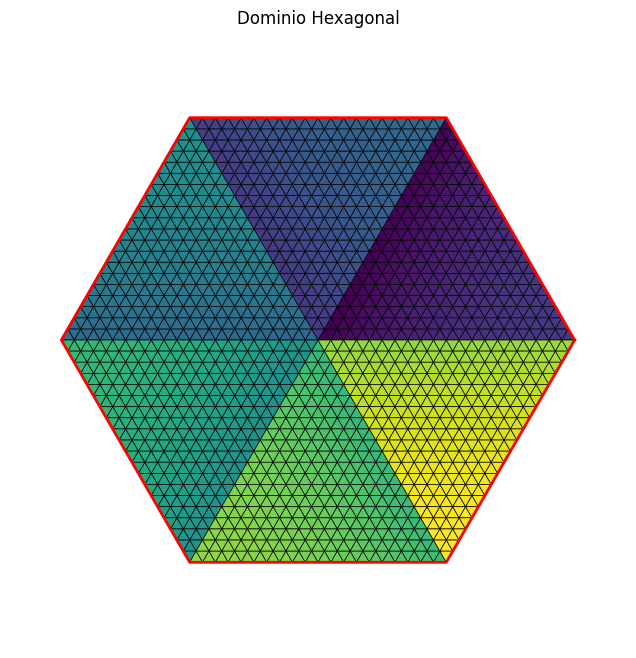

In [61]:
class HexagonalDomain:
    def __init__(self, R, m):
        self.R = R
        self.m = m
        self.hexagon_vertices = self.generate_hexagon_vertices()
        self.triangles = self.hexagon_triangles()
        # Refinar por triángulo y luego combinar nodos coincidentes
        raw_nodes, raw_elements = self.refine_triangles()
        self.nodes, self.elements = self.merge_nodes(raw_nodes, raw_elements, tol=1e-8)
        #self.area_value = self.area_elements()
        self.boundary_nodes = self.identify_boundary_nodes()

    def generate_hexagon_vertices(self):
        theta = np.arange(6) * np.pi / 3
        x = self.R * np.cos(theta)
        y = self.R * np.sin(theta)
        return np.column_stack((x, y))

    def hexagon_triangles(self):
        center = np.array([0.0, 0.0])
        triangles = []
        for i in range(6):
            A = center
            B = self.hexagon_vertices[i]
            C = self.hexagon_vertices[(i + 1) % 6]
            triangles.append((A, B, C))
        return triangles

    def refine_single_triangle(self, A, B, C):
        m = self.m
        nodes = []
        for i in range(m + 1):
            for j in range(m + 1 - i):
                P = (i / m) * B + (j / m) * C + (1 - (i + j) / m) * A
                nodes.append(P)
        nodes = np.array(nodes)

        elements = []
        def idx(i, j):
            # Índice por filas (fila i tiene m+1-i nodos)
            return int(i * (m + 1) - (i * (i - 1)) // 2 + j)

        for i in range(m):
            for j in range(m - i):
                n1 = idx(i, j)
                n2 = idx(i + 1, j)
                n3 = idx(i, j + 1)
                elements.append([n1, n2, n3])
                if j < m - i - 1:
                    n4 = idx(i + 1, j + 1)
                    elements.append([n2, n4, n3])

        return nodes, np.array(elements, dtype=int)

    def refine_triangles(self):
        all_nodes = []
        all_elements = []
        offset = 0
        for (A, B, C) in self.triangles:
            nodes, elems = self.refine_single_triangle(A, B, C)
            elems = elems + offset
            all_nodes.append(nodes)
            all_elements.append(elems)
            offset += len(nodes)
        all_nodes = np.vstack(all_nodes)
        all_elements = np.vstack(all_elements)
        return all_nodes, all_elements

    def merge_nodes(self, nodes, elements, tol=1e-8):
        decimals = int(-np.log10(tol)) if tol < 1 else 8
        rounded = np.round(nodes, decimals=decimals)

        # Unique rows preserving first occurrence
        dtype = np.dtype((np.void, rounded.dtype.itemsize * rounded.shape[1]))
        b = np.ascontiguousarray(rounded).view(dtype)
        unique_b, idx_unique, idx_inv = np.unique(b, return_index=True, return_inverse=True)
        unique_nodes = rounded[idx_unique]
        new_elements = idx_inv[elements]

        return unique_nodes.astype(float), new_elements.astype(int)


    def area_single_element(self, element):
        pts = self.nodes[element].squeeze()
        (x1, y1), (x2, y2), (x3, y3) = pts
        area = 0.5 * abs(
            x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2)
        )
        return area

    def area_elements(self):
        return np.array([self.area_single_element(e) for e in self.elements])

    def identify_boundary_nodes(self, tol=1e-6):
        R = self.R
        dists = np.sqrt(self.nodes[:,0]**2 + self.nodes[:,1]**2)
        return np.where(np.abs(dists - R) < tol)[0].tolist()

    def plot(self):
        plt.figure(figsize=(8,8))
        n_el = len(self.elements)
        cmap = plt.get_cmap('viridis', n_el)
        for i, element in enumerate(self.elements):
            pts = self.nodes[element].squeeze()
            color = cmap(i)
            polygon = plt.Polygon(pts, edgecolor='black', facecolor=color, lw=0.5)
            plt.gca().add_patch(polygon)
        # hex border
        hv = self.hexagon_vertices
        plt.plot(np.append(hv[:,0], hv[0,0]), np.append(hv[:,1], hv[0,1]), 'r-', lw=2)
        plt.xlim(-self.R-0.2, self.R+0.2)
        plt.ylim(-self.R-0.2, self.R+0.2)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Dominio Hexagonal')
        plt.axis('off')
        plt.show()

# Crear dominio hexagonal y plotear
R = 1.0
m = 20
domain = HexagonalDomain(R, m)
domain.plot()


Ahora que hemos definido la malla, resolveremos el problema de Poisson utilizando el método de elementos finitos.
El primer paso es definir las funciones de interpolación dentro de cada elemento. Supondremos que dentro de cada elemento triangular, el desplazamiento varía de manera lineal. Esta es la suposición clave en elementos finitos. Por lo tanto, el desplazamiento $u(x, y)$ en todo el elemento puede aproximarse como:

$$
u(x, y) \approx N_a(x, y) u_a + N_b(x, y) u_b + N_c(x, y) u_c,
$$

donde $u_a, u_b, u_c$ son los valores del desplazamiento en los vértices del triángulo, y $N_a, N_b, N_c$ son las funciones de forma asociadas a cada nodo. Podemos expresar estas funciones como combinaciones lineales en coordenadas cartesianas:

$$
N_i(x, y) = a_i + b_i x + c_i y, \quad i = a, b, c.
$$

Las funciones de forma deben cumplir que:

$$
\begin{aligned}
N_a(A) &= 1, & N_a(B) &= 0, & N_a(C) &= 0, \\
N_b(A) &= 0, & N_b(B) &= 1, & N_b(C) &= 0, \\
N_c(A) &= 0, & N_c(B) &= 0, & N_c(C) &= 1.\
\end{aligned}
$$

Sustituyendo estas condiciones en las expresiones lineales $N_i = a_i + b_i x + c_i y$, se obtiene un sistema de ecuaciones para los coeficientes $(a_i, b_i, c_i)$.
Por ejemplo, para el nodo $A$ se tiene:

$$
\begin{bmatrix}
1 & x_a & y_a \\
1 & x_b & y_b \\
1 & x_c & y_c
\end{bmatrix}
\begin{bmatrix}
a_a \\ b_a \\ c_a 
\end{bmatrix}

=
\begin{bmatrix}
1 \\ 0 \\ 0
\end{bmatrix},
$$

y de manera análoga, para los nodos $B$ y $C$:

$$
\begin{bmatrix}
1 & x_a & y_a \\
1 & x_b & y_b \\
1 & x_c & y_c\
\end{bmatrix}
\begin{bmatrix}
a_b \\ b_b \\ c_b
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 1 \\ 0
\end{bmatrix},
\qquad
\begin{bmatrix}
1 & x_a & y_a \\
1 & x_b & y_b \\
1 & x_c & y_c
\end{bmatrix}
\begin{bmatrix}
a_c \\ b_c \\ c_c
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 0 \\ 1
\end{bmatrix}.
$$

Esta matriz cuadrada que multiplica a los vectores de coeficientes es la matriz de área del triángulo, y su determinante corresponde al doble del área del mismo:

$$
2A =
\begin{vmatrix}
1 & x_a & y_a \\
1 & x_b & y_b \\
1 & x_c & y_c\
\end{vmatrix}.
$$

Resolviendo dicho sistema para cada nodo, se obtiene que:

$$
\begin{aligned}
N_a(x, y) &= \frac{1}{2A}\left[(x_b y_c - x_c y_b) + (y_b - y_c)x + (x_c - x_b)y\right], \\
N_b(x, y) &= \frac{1}{2A}\left[(x_c y_a - x_a y_c) + (y_c - y_a)x + (x_a - x_c)y\right], \\
N_c(x, y) &= \frac{1}{2A}\left[(x_a y_b - x_b y_a) + (y_a - y_b)x + (x_b - x_a)y\right].
\end{aligned}
$$
Ahora hallamos la matriz de rigidez para un triángulo, que se obtiene integrando el producto de los gradientes de las funciones de forma:

$$
K^e_{ij}=\int_{\Omega_e}\nabla N_i\cdot\nabla N_j\,dA.
$$

Como $\nabla N_i$ es constante en el elemento, si denotamos el área del elemento por $A_e$,
$$
\nabla N_i=\frac{1}{2A_e}\begin{bmatrix}b_i & c_i\end{bmatrix},
$$
entonces

$$
K^e_{ij} = A_e\left(\nabla N_i\cdot\nabla N_j\right)
= A_e \left(\frac{1}{2A_e}\right)^2 (b_i b_j + c_i c_j)
= \frac{1}{4A_e}\bigl(b_i b_j + c_i c_j\bigr).
$$

Por lo tanto la matriz elemental completa es

$$
K^e=\frac{1}{4A_e}
\begin{bmatrix}
b_1^2 + c_1^2 & b_1 b_2 + c_1 c_2 & b_1 b_3 + c_1 c_3\\
b_2 b_1 + c_2 c_1 & b_2^2 + c_2^2 & b_2 b_3 + c_2 c_3\\
b_3 b_1 + c_3 c_1 & b_3 b_2 + c_3 c_2 & b_3^2 + c_3^2
\end{bmatrix},
$$

donde, recordando la notación $(1\!\leftrightarrow\!A,\;2\!\leftrightarrow\!B,\;3\!\leftrightarrow\!C)$,

$$
\begin{aligned}
b_1 &= y_2 - y_3,\quad & c_1 &= x_3 - x_2,\\
b_2 &= y_3 - y_1,\quad & c_2 &= x_1 - x_3,\\
b_3 &= y_1 - y_2,\quad & c_3 &= x_2 - x_1,
\end{aligned}
\qquad
2A_e =
\begin{vmatrix}
1 & x_1 & y_1\\
1 & x_2 & y_2\\
1 & x_3 & y_3
\end{vmatrix}.
$$

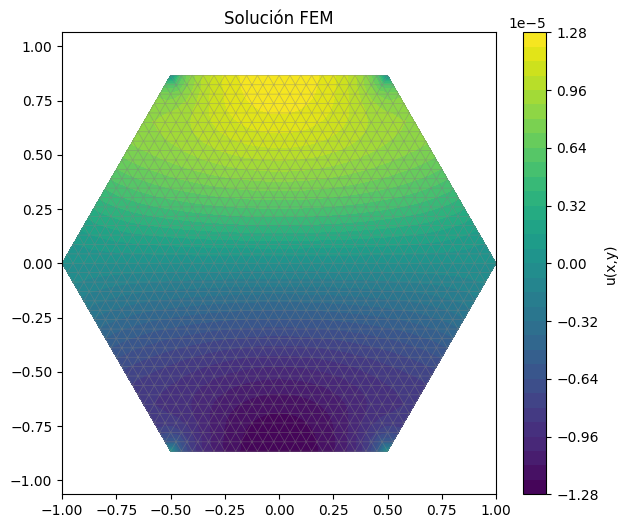

In [67]:
class PoissonFEM:
    def __init__(self, domain, f):
        self.domain = domain
        self.f = f
        self.K = None
        self.F = None
        self.u = None

    def matriz_elemental(self, element):
        pts = self.domain.nodes[element].squeeze()
        (x1,y1),(x2,y2),(x3,y3) = pts
        A = self.domain.area_single_element(element)
        b1, c1 = y2 - y3, x3 - x2
        b2, c2 = y3 - y1, x1 - x3
        b3, c3 = y1 - y2, x2 - x1
        K = (1/(4*A)) * np.array([
            [b1*b1 + c1*c1, b1*b2 + c1*c2, b1*b3 + c1*c3],
            [b2*b1 + c2*c1, b2*b2 + c2*c2, b2*b3 + c2*c3],
            [b3*b1 + c3*c1, b3*b2 + c3*c2, b3*b3 + c3*c3]
        ])
        return K

    def ensamblar_sistema(self, f=lambda x,y:0):
        n_nodes = len(self.domain.nodes)
        K_global = np.zeros((n_nodes,n_nodes))
        F_global = np.zeros(n_nodes)
        for element in self.domain.elements:
            Ke = self.matriz_elemental(element)
            Ae = self.domain.area_single_element(element)
            pts = self.domain.nodes[element].squeeze()
            xm = pts[:,0].mean(); ym = pts[:,1].mean()
            fe = f(xm, ym)
            Fe = fe * Ae / 3 * np.ones(3)
            for i_local, i_global in enumerate(element):
                F_global[i_global] += Fe[i_local]
                for j_local, j_global in enumerate(element):
                    K_global[i_global, j_global] += Ke[i_local, j_local]
        self.K = K_global
        self.F = F_global

    def aplicar_condiciones_frontera(self, boundary_nodes, g):
        for node in boundary_nodes:
            x, y = self.domain.nodes[node]
            self.K[node, :] = 0
            self.K[:, node] = 0
            self.K[node, node] = 1.0
            self.F[node] = g(x, y)

    def solucionar(self):
        self.u = np.linalg.solve(self.K, self.F)
        return self.u


    def plot_displacements(self):
        if self.u is None:
            raise ValueError("Resuelve primero con 'solucionar()'.")
        x = self.domain.nodes[:,0]; y = self.domain.nodes[:,1]
        triang = mtri.Triangulation(x, y, self.domain.elements.squeeze())
        plt.figure(figsize=(7,6))
        tpc = plt.tricontourf(triang, self.u, levels=40, cmap='viridis')
        plt.colorbar(tpc, label='u(x,y)')
        plt.triplot(triang, color='gray', lw=0.5, alpha=0.5)
        plt.title('Solución FEM')
        plt.axis('equal')
        plt.show()

# Uso:
f_fun = lambda x,y: np.sin(y/10000)
poisson = PoissonFEM(domain, f_fun)
poisson.ensamblar_sistema(f=f_fun)
poisson.aplicar_condiciones_frontera(domain.boundary_nodes, g=lambda x,y: 0.0)
u = poisson.solucionar()
poisson.plot_displacements()



# Task 2: Monte Carlo Analysis

Perform $N = 100$ simulations with random parameters:

1. Sampling: for each iteration $i = 1,\dots,100$:
   - Generate random samples $R_i, \alpha_i, \beta_i, \gamma_i, \theta_i$.
   - Solve the FEM problem.
   - Store $u_{\max,i}$ 

2. Statistical analysis: calculate and plot:
   - Histogram of the distribution of $u_{\max}$ and report its mean and standard deviation.
   - 95% confidence interval.

3. Sensitivity analysis:
   - Compute correlations between the parameters and the maximum deformation.
   - Identify which parameter has the largest influence.

# Task 3: Parametric Study

Select one parameter of your choice and perform a univariate analysis:

1. Fix all parameters at their mean values except the selected parameter.
2. Generate $N = 100$ random samples for the selected parameter only.
3. For each sample, solve the FEM problem and compute $u_{\max}$.
4. Plot $u_{\max}$ versus the selected parameter and discuss the observed functional relationship.

Conclude the exercise by analyzing the results in light of the order of magnitude of the wavelength in the visible spectrum.